In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [71]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [72]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [73]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [74]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [75]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  392379
Total transactions in test dataset:  98134


## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части + указанием места в leaderboard при решении дополнительной

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

In [76]:
raw_df = raw_df.drop("target_sum", axis=1) #убираем столбец target_sum

In [77]:
raw_df['target_flag'].value_counts()

1    320103
0    170410
Name: target_flag, dtype: int64

In [78]:
#общая сумма транзакций по каждой из trx_category - видим какие категории транзакции (trx_category) наиболее популярны
raw_df["trx_category"].value_counts()

POS               416425
DEPOSIT            21216
WD_ATM_ROS         19104
WD_ATM_PARTNER      9948
C2C_IN              7306
WD_ATM_OTHER        7140
C2C_OUT             5456
BACK_TRX            2687
CAT                 1197
CASH_ADV              34
Name: trx_category, dtype: int64

In [79]:
#общая сумма транзакции по основным валютам (в %)
raw_df["currency"].value_counts(normalize=True).head(10)

810    0.973764
978    0.011286
840    0.003916
933    0.001144
985    0.000862
764    0.000840
203    0.000813
949    0.000795
975    0.000605
826    0.000544
Name: currency, dtype: float64

In [80]:
raw_df.currency.describe()

count    490513.000000
mean        810.601854
std          38.223123
min          32.000000
25%         810.000000
50%         810.000000
75%         810.000000
max         986.000000
Name: currency, dtype: float64

In [81]:
#общая сумма транзакций по категориям MCC кодов (в %) - видим самые популярные MCC коды
raw_df["MCC"].value_counts(normalize=True).head(20)

5411    0.247985
6011    0.110868
5814    0.084302
5812    0.061216
5499    0.055528
5541    0.040399
5912    0.038180
5999    0.026652
6012    0.020501
5921    0.017488
5331    0.015578
4121    0.012774
5211    0.012766
4829    0.012650
5691    0.010522
5261    0.009792
4111    0.008893
5977    0.008766
5200    0.007054
5732    0.006669
Name: MCC, dtype: float64

In [82]:
#общая сумма транзакций по категориям MCC кодов для каждого уникального клиента
raw_df_grouped = raw_df[
    ['cl_id', 'amount', 'MCC']
].groupby(['cl_id', 'MCC']).agg(['sum', 'count'])

aggregated_dataset = raw_df_grouped.unstack().fillna(0)
aggregated_dataset = raw_df_grouped.unstack()

In [83]:
raw_df_grouped.head(10)

amount      
                 sum count
cl_id MCC                 
0     5200   5023.00     1
      5411   2031.00     1
      5921    767.00     1
      6011  20000.00     1
      6012  36562.00     1
1     4111     17.10     1
      4468     34.00     1
      5200     23.90     1
      5411  14629.46    12
      5499    492.80     2

In [84]:
aggregated_dataset.head(10)

amount                                              ...              \
         sum                                              ...  count        
MCC     742  763  780  1520 1711 1731 1750 1799 2741 2842 ...   8699 8911   
cl_id                                                     ...               
0        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    NaN  NaN   
1        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    NaN  NaN   
5        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    NaN  NaN   
9        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    NaN  NaN   
10       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    NaN  NaN   
11       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    NaN  NaN   
14       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    NaN  NaN   
20       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    NaN  NaN   
21       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    NaN  NaN   
22       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    NaN  NaN   

                                               
                                               
MCC   8931 8999 9211 9222 9311 9399 9402 9405  
cl_id                                          
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1      NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  
5      NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  
9      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
10     NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  
11     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
14     NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  
20     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
21     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
22     NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  

[10 rows x 688 columns]

In [85]:
import sqlite3 #поработаем с нашим датасетом в виде БД в sql

In [86]:
#создаём пустой файл в коммандной строке touch transactions.db

In [87]:
conn = sqlite3.connect('transactions.db') #создаём connection с sql БД 

In [88]:
raw_df.to_sql('transactions_raw', if_exists='replace', con=conn) #заполнили исходными транзакциями базу данных

In [89]:
#проверяем правильно ли всё законнектилось
check = pd.io.sql.read_sql("""
        select * from transactions_raw limit 100
        """, conn
)

In [90]:
check

,index,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,0,01/10/2017,0,5200,None,810,21OCT17:00:00:00,5023.00,POS,0
1,1,01/10/2017,0,6011,None,810,12OCT17:12:24:07,20000.00,DEPOSIT,0
2,2,01/12/2017,0,5921,None,810,05DEC17:00:00:00,767.00,POS,0
3,3,01/10/2017,0,5411,None,810,21OCT17:00:00:00,2031.00,POS,0
4,4,01/10/2017,0,6012,None,810,24OCT17:13:14:24,36562.00,C2C_OUT,0
5,5,01/10/2017,1,5814,None,810,16OCT17:00:00:00,380.00,POS,0
6,6,01/10/2017,1,5814,None,810,10OCT17:00:00:00,378.00,POS,0
7,7,01/10/2017,1,5814,None,810,16OCT17:00:00:00,199.00,POS,0
8,8,01/10/2017,1,5814,None,810,11OCT17:00:00:00,400.00,POS,0
9,9,01/07/2017,1,5411,None,810,26JUL17:00:00:00,598.00,POS,0


In [91]:
# проверяем соответствует ли размер БД исходному датасету
pd.io.sql.read_sql("""
select count(*), count(distinct cl_id) from transactions_raw
""", conn
)

,count(*),count(distinct cl_id)
0,490513,5000


In [92]:
raw_df.MCC.value_counts().head()

5411    121640
6011     54382
5814     41351
5812     30027
5499     27237
Name: MCC, dtype: int64

In [93]:
#группируем суммарные траты по наиболее популярным MCC для каждого клиента cl_id (target_flag - целевая переменная - для клиента не меняется)
#добавили ещё фичи - средние траты по тем же категориям
datamart_check = pd.io.sql.read_sql("""
    select 
        cl_id, 
        target_flag,
        sum(case when MCC = 5411 then amount else 0 end) as MCC_5411,
        sum(case when MCC = 6011 then amount else 0 end) as MCC_6011,
        sum(case when MCC = 5814 then amount else 0 end) as MCC_5814,
        sum(case when MCC = 5812 then amount else 0 end) as MCC_5812,
        sum(case when MCC = 5499 then amount else 0 end) as MCC_5499,
        /*--------------------------average------------------------*/
        avg(case when MCC = 5411 then amount else 0 end) as MCC_5411_avg,
        avg(case when MCC = 6011 then amount else 0 end) as MCC_6011_avg,
        avg(case when MCC = 5814 then amount else 0 end) as MCC_5814_avg,
        avg(case when MCC = 5812 then amount else 0 end) as MCC_5812_avg,
        avg(case when MCC = 5499 then amount else 0 end) as MCC_5499_avg
    from transactions_raw
    group by 1, 2
    order by 1        
    """, conn)

In [94]:
datamart_check

,cl_id,target_flag,MCC_5411,MCC_6011,MCC_5814,MCC_5812,MCC_5499,MCC_5411_avg,MCC_6011_avg,MCC_5814_avg,MCC_5812_avg,MCC_5499_avg
0,0,0,2031.00,20000.0,0.00,0.00,0.00,406.200000,4000.000000,0.000000,0.000000,0.000000
1,1,0,14629.46,145000.0,82441.17,3180.01,492.80,140.667885,1394.230769,792.703558,30.577019,4.738462
2,5,1,44925.40,208000.0,247.00,3309.00,7196.70,316.376056,1464.788732,1.739437,23.302817,50.680986
3,9,0,39.00,540000.0,0.00,0.00,0.00,1.000000,13846.153846,0.000000,0.000000,0.000000
4,10,0,53920.36,854000.0,2010.00,319.00,13225.02,116.458661,1844.492441,4.341253,0.688985,28.563758
5,11,0,31084.62,182000.0,5653.00,11814.80,383.60,143.247097,838.709677,26.050691,54.446083,1.767742
6,14,1,20408.96,37000.0,23894.06,5659.00,827.00,150.065882,272.058824,175.691618,41.610294,6.080882
7,20,0,9834.43,215000.0,0.00,3023.33,1247.73,127.719870,2792.207792,0.000000,39.264026,16.204286
8,21,0,25978.04,65000.0,4853.00,7540.00,1277.45,209.500323,524.193548,39.137097,60.806452,10.302016
9,22,0,241.82,139000.0,0.00,0.00,2610.00,4.098644,2355.932203,0.000000,0.000000,44.237288


In [95]:
#datamart_check
x = datamart_check.drop("target_flag", axis=1)
y = datamart_check["target_flag"].copy()

In [96]:
#Нормировка значений - нужна, т.к. большой разброс по суммам по различным МСС
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [99]:
columns = x.columns

x_scaled = scaler.transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=columns)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
x_scaled.head(10)

,cl_id,MCC_5411,MCC_6011,MCC_5814,MCC_5812,MCC_5499,MCC_5411_avg,MCC_6011_avg,MCC_5814_avg,MCC_5812_avg,MCC_5499_avg
0,-1.717403,-0.445983,-0.416806,-0.456716,-0.053948,-0.140093,0.101758,-0.137468,-0.364218,-0.042959,-0.049269
1,-1.717067,-0.220359,-0.229931,9.345914,-0.037889,-0.122711,-0.174863,-0.285005,8.276770,-0.032636,-0.045697
2,-1.715723,0.322204,-0.135746,-0.427346,-0.037237,0.113754,0.008183,-0.281010,-0.345257,-0.035092,-0.011064
3,-1.714380,-0.481657,0.360594,-0.456716,-0.053948,-0.140093,-0.320364,0.420013,-0.364218,-0.042959,-0.049269
4,-1.714044,0.483293,0.830024,-0.217717,-0.052337,0.326389,-0.200084,-0.259511,-0.316896,-0.042726,-0.027736
5,-1.713708,0.074332,-0.174616,0.215452,0.005717,-0.126562,-0.172176,-0.316458,-0.080249,-0.024578,-0.047936
6,-1.712700,-0.116856,-0.391391,2.384397,-0.025370,-0.110922,-0.165073,-0.348541,1.550935,-0.028911,-0.044685
7,-1.710684,-0.306233,-0.125281,-0.456716,-0.038680,-0.096082,-0.188352,-0.205852,-0.364218,-0.029703,-0.037053
8,-1.710349,-0.017120,-0.349531,0.120328,-0.015871,-0.095034,-0.103156,-0.334265,0.062402,-0.022431,-0.041503
9,-1.710013,-0.478025,-0.238901,-0.456716,-0.053948,-0.048031,-0.317136,-0.230554,-0.364218,-0.042959,-0.015921


In [101]:
raw_df.MCC.value_counts().head(20).index.tolist()

[5411,
 6011,
 5814,
 5812,
 5499,
 5541,
 5912,
 5999,
 6012,
 5921,
 5331,
 4121,
 5211,
 4829,
 5691,
 5261,
 4111,
 5977,
 5200,
 5732]

In [102]:
#упрощённый способ быстрой записи строк для запросов (чтобы не копипастить код - его можно сгенерировать)
MCC_list = raw_df.MCC.value_counts().head(20).index.tolist()
for MCC_code in MCC_list:
    print(
        'sum(case when MCC = {0} then amount else 0 end) as MCC_{0},'.format(MCC_code)
    )

sum(case when MCC = 5411 then amount else 0 end) as MCC_5411,
sum(case when MCC = 6011 then amount else 0 end) as MCC_6011,
sum(case when MCC = 5814 then amount else 0 end) as MCC_5814,
sum(case when MCC = 5812 then amount else 0 end) as MCC_5812,
sum(case when MCC = 5499 then amount else 0 end) as MCC_5499,
sum(case when MCC = 5541 then amount else 0 end) as MCC_5541,
sum(case when MCC = 5912 then amount else 0 end) as MCC_5912,
sum(case when MCC = 5999 then amount else 0 end) as MCC_5999,
sum(case when MCC = 6012 then amount else 0 end) as MCC_6012,
sum(case when MCC = 5921 then amount else 0 end) as MCC_5921,
sum(case when MCC = 5331 then amount else 0 end) as MCC_5331,
sum(case when MCC = 4121 then amount else 0 end) as MCC_4121,
sum(case when MCC = 5211 then amount else 0 end) as MCC_5211,
sum(case when MCC = 4829 then amount else 0 end) as MCC_4829,
sum(case when MCC = 5691 then amount else 0 end) as MCC_5691,
sum(case when MCC = 5261 then amount else 0 end) as MCC_5261,
sum(case

In [103]:
corr_matrix = datamart_check.corr() #видим, что корреляция признаков слабая
corr_matrix["target_flag"].sort_values(ascending=False)

target_flag     1.000000
MCC_5814        0.170680
MCC_5411        0.102431
MCC_5814_avg    0.079955
MCC_5499        0.037493
MCC_6011        0.032480
MCC_5812        0.030934
MCC_5812_avg    0.022071
MCC_5499_avg    0.010192
MCC_5411_avg    0.009492
MCC_6011_avg   -0.130944
cl_id          -0.393239
Name: target_flag, dtype: float64

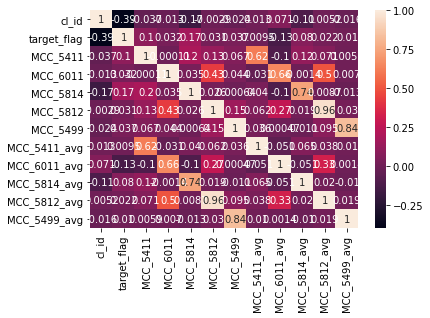

In [104]:
sns.heatmap(corr_matrix, annot=True,
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)

In [105]:
#с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) 
#и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке

In [106]:
from sklearn.linear_model import LinearRegression

In [107]:
#datamart_check

lin_reg = LinearRegression().fit(x, y)
y_predictions = lin_reg.predict(x)

from sklearn.metrics import mean_squared_error #среднеквадратичная ошибка

lin_mse = mean_squared_error(y, y_predictions)
lin_rmse = np.sqrt(lin_mse)
# Training error
lin_rmse

0.44608496971021977

In [108]:
from sklearn.metrics import auc, roc_curve, roc_auc_score

In [109]:
def show_auc(y, y_predictions, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_predictions)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

Test:
ROC AUC: 0.7623


0.7622965372551005

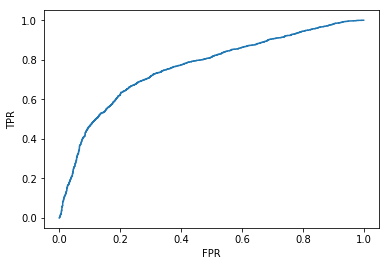

In [110]:
print('Test:')
show_auc(y, y_predictions, 'test')

In [26]:
#генерация различных признаков по неструктурированным данным

In [126]:
raw_df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


In [130]:
raw_df['channel_type'].describe()

count     487603
unique         5
top        type1
freq      299247
Name: channel_type, dtype: object

In [132]:
raw_df['channel_type'].value_counts()

type1    299247
type2    175013
type5      5587
type4      4476
type3      3280
Name: channel_type, dtype: int64

In [127]:
#найдём сумму пропущенных значений для channel_type (сумму значений True для isnull)
sum(raw_df['channel_type'].isnull())

2910

In [138]:
#заменим пропущенные значения для channel_type на средние значения по столбцу
raw_df.channel_type.fillna(value = 0)

0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             0
10            0
11            0
12            0
13            0
14            0
15            0
16            0
17            0
18            0
19            0
20            0
21            0
22            0
23            0
24            0
25            0
26            0
27            0
28            0
29            0
          ...  
490483    type1
490484    type1
490485    type1
490486    type1
490487    type1
490488    type1
490489    type1
490490    type1
490491    type1
490492    type1
490493    type1
490494    type1
490495    type1
490496    type1
490497    type1
490498    type1
490499    type1
490500    type1
490501    type1
490502    type1
490503    type1
490504    type1
490505    type1
490506    type1
490507    type1
490508    type1
490509    type1
490510    type1
490511    type1
490512    type1
Name: channel_type, Leng

In [144]:
#найдём сумму пропущенных значений для trx_category (сумму значений True для isnull)
sum(raw_df['trx_category'].isnull())

0

In [140]:
df_dummies = pd.get_dummies(raw_df, columns=['channel_type', 'trx_category'])

In [141]:
df_dummies.head()

,PERIOD,cl_id,MCC,currency,TRDATETIME,amount,target_flag,channel_type_type1,channel_type_type2,channel_type_type3,...,trx_category_BACK_TRX,trx_category_C2C_IN,trx_category_C2C_OUT,trx_category_CASH_ADV,trx_category_CAT,trx_category_DEPOSIT,trx_category_POS,trx_category_WD_ATM_OTHER,trx_category_WD_ATM_PARTNER,trx_category_WD_ATM_ROS
0,01/10/2017,0,5200,810,21OCT17:00:00:00,5023.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,01/10/2017,0,6011,810,12OCT17:12:24:07,20000.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,01/12/2017,0,5921,810,05DEC17:00:00:00,767.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,01/10/2017,0,5411,810,21OCT17:00:00:00,2031.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,01/10/2017,0,6012,810,24OCT17:13:14:24,36562.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [81]:
df_dummies.isnull().sum() # проверяем наличие пропусков

PERIOD                         0
cl_id                          0
MCC                            0
currency                       0
TRDATETIME                     0
amount                         0
target_flag                    0
day_of_transaction             0
hour_of_transaction            0
channel_type_type1             0
channel_type_type2             0
channel_type_type3             0
channel_type_type4             0
channel_type_type5             0
trx_category_BACK_TRX          0
trx_category_C2C_IN            0
trx_category_C2C_OUT           0
trx_category_CASH_ADV          0
trx_category_CAT               0
trx_category_DEPOSIT           0
trx_category_POS               0
trx_category_WD_ATM_OTHER      0
trx_category_WD_ATM_PARTNER    0
trx_category_WD_ATM_ROS        0
dtype: int64

In [145]:
corr_matrix = df_dummies.corr()
corr_matrix["target_flag"].sort_values(ascending=False)

target_flag                    1.000000
channel_type_type2             0.367200
trx_category_WD_ATM_OTHER      0.061114
channel_type_type5             0.028123
trx_category_WD_ATM_ROS        0.025250
channel_type_type4             0.023820
trx_category_WD_ATM_PARTNER    0.018318
trx_category_POS               0.014862
MCC                            0.013118
trx_category_CAT               0.010054
channel_type_type3             0.006436
trx_category_C2C_OUT           0.004469
trx_category_CASH_ADV         -0.002154
amount                        -0.003336
trx_category_BACK_TRX         -0.009833
currency                      -0.013644
trx_category_C2C_IN           -0.028377
trx_category_DEPOSIT          -0.083039
channel_type_type1            -0.367094
cl_id                         -0.410436
Name: target_flag, dtype: float64

In [112]:
corr_matrix = df_dummies.corr()
corr_matrix

NameError: name 'df_dummies' is not defined

In [ ]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w') ) 
    tmp_df = dataset.groupby(['cl_id','day_of_transaction'])['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['day_of_transaction'].unique()]
    tmp_df.rename(columns={old_col: 'day_' + old_col for old_col in old_columns}, inplace=True)
    return tmp_df   
    

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') ) 
    return dataset.groupby(['cl_id','hour_of_transaction'])['hour_of_transaction'].size().unstack().fillna(0).reset_index()

#transaction_by_day_count(raw_df) 
#transaction_by_hour_count(raw_df)